# Описание проекта: телекоммуникации

Оператор связи «ТелеДом» хочет бороться с оттоком клиентов. Для этого его сотрудники начнут предлагать промокоды и специальные условия всем, кто планирует отказаться от услуг связи. Чтобы заранее находить таких пользователей, «ТелеДому» нужна модель, которая будет предсказывать, разорвёт ли абонент договор. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и услугах. Ваша задача — обучить на этих данных модель для прогноза оттока клиентов.

# Описание услуг

Оператор предоставляет два основных типа услуг: 
- Стационарную телефонную связь. Телефон можно подключить к нескольким линиям одновременно.
- Интернет. Подключение может быть двух типов: через телефонную линию (DSL, от англ. digital subscriber line — «цифровая абонентская линия») или оптоволоконный кабель (Fiber optic).

Также доступны такие услуги:
- Интернет-безопасность: антивирус (DeviceProtection) и блокировка небезопасных сайтов (OnlineSecurity);
- Выделенная линия технической поддержки (TechSupport);
- Облачное хранилище файлов для резервного копирования данных (OnlineBackup);
- Стриминговое телевидение (StreamingTV) и каталог фильмов (StreamingMovies).


Клиенты могут платить за услуги каждый месяц или заключить договор на 1–2 года. Возможно оплатить счёт разными способами, а также получить электронный чек.

# Описание данных

Данные состоят из нескольких файлов, полученных из разных источников:

- contract_new.csv — информация о договоре;
- personal_new.csv — персональные данные клиента;
- internet_new.csv — информация об интернет-услугах;
- phone_new.csv — информация об услугах телефонии.

Файл contract_new.csv
- customerID — идентификатор абонента;
- BeginDate — дата начала действия договора;
- EndDate — дата окончания действия договора;
- Type — тип оплаты: раз в год-два или ежемесячно;
- PaperlessBilling — электронный расчётный лист;
- PaymentMethod — тип платежа;
- MonthlyCharges — расходы за месяц;
- TotalCharges — общие расходы абонента.

Файл personal_new.csv
- customerID — идентификатор пользователя;
- gender — пол;
- SeniorCitizen — является ли абонент пенсионером;
- Partner — есть ли у абонента супруг или супруга;
- Dependents — есть ли у абонента дети.

Файл internet_new.csv
- customerID — идентификатор пользователя;
- InternetService — тип подключения;
- OnlineSecurity — блокировка опасных сайтов;
- OnlineBackup — облачное хранилище файлов для резервного копирования данных;
- DeviceProtection — антивирус;
- TechSupport — выделенная линия технической поддержки;
- StreamingTV — стриминговое телевидение;
- StreamingMovies — каталог фильмов.

Файл phone_new.csv
- customerID — идентификатор пользователя;
- MultipleLines — подключение телефона к нескольким линиям одновременно.

Во всех файлах столбец customerID содержит код клиента.

Информация о договорах актуальна на 1 февраля 2020 года.

# Импорты

In [1]:
pip install --upgrade scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install phik

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install shap

Note: you may need to restart the kernel to use updated packages.


In [4]:
import time
import datetime
import re
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import shap
import logging

import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.stats as stats

import phik
from phik.report import plot_correlation_matrix
from phik import report

from functools import reduce

from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve, confusion_matrix, make_scorer
from scipy.interpolate import interp1d

from catboost import CatBoostClassifier, Pool

Зададим константу RANDOM_STATE в соответствии с требованием для группы

In [5]:
RANDOM_STATE = 50824

# Шаг 1. Загрузка данных

In [6]:
 def read_data(file_name):
    try:
        if basename(normpath(getcwd())) == 'praktikum_new':
            df_ = pd.read_csv(f".\datasets\\{file_name}")#local
        else:
            df_ = pd.read_csv(f"/datasets/{file_name}")#server
    except:
        df_ = pd.read_csv(f"/datasets/{file_name}")#server
    return df_

df_contract = read_data('contract_new.csv')
df_personal = read_data('personal_new.csv')
df_internet = read_data('internet_new.csv')
df_phone = read_data('phone_new.csv')

# Просмотр данных

In [7]:
def analyze_dataframe(df, df_name):
    print(f'Просмотр {df_name}')
    display(df.sample(5))
    print(f'Признаков в {df_name}:', df.shape[1], '\n')
    print(f'Признаки в {df_name}:', '\n', df.columns.tolist(), '\n')
    print(f'Типы данных в {df_name}:', '\n')
    df.info()
    print('\n')
    print(f'Пропуски в {df_name}:', df.isnull().sum().sum())
    print(f'Дубликаты в {df_name}:', df.duplicated().sum(), '\n')
    for column in df.columns:
        print(f'Категории признака {column} в {df_name}:', df[column].unique(), '\n')
    print('\n', f'Описание {df_name}')
    display(df.describe())

In [8]:
analyze_dataframe(df_contract, 'df_contract')

Просмотр df_contract


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
596,8208-EUMTE,2018-10-01,No,Two year,No,Mailed check,54.85,903.93
2798,7209-JCUDS,2018-12-01,No,Month-to-month,Yes,Electronic check,94.90,1328.6
3717,0655-YDGFJ,2017-09-01,2019-10-01,Month-to-month,No,Bank transfer (automatic),48.95,1297.17
2605,1790-NESIO,2019-01-01,No,Two year,Yes,Mailed check,20.40,265.2
5830,6754-WKSHP,2017-08-01,No,One year,No,Bank transfer (automatic),25.35,760.5


Признаков в df_contract: 8 

Признаки в df_contract: 
 ['customerID', 'BeginDate', 'EndDate', 'Type', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges'] 

Типы данных в df_contract: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


Пропуски в df_contract: 0
Дубликаты в df_contract: 0 

Категории признака customerID в df_contract: ['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-L

,MonthlyCharges
count,7043.000000
mean,64.761692
std,30.090047
min,18.250000
25%,35.500000
50%,70.350000
75%,89.850000
max,118.750000


In [9]:
analyze_dataframe(df_personal, 'df_personal')

Просмотр df_personal


,customerID,gender,SeniorCitizen,Partner,Dependents
4947,4735-ASGMA,Male,0,No,No
4325,2700-LUEVA,Male,0,No,No
6065,4458-KVRBJ,Male,0,No,No
6283,6956-SMUCM,Female,0,No,No
764,7969-FFOWG,Male,0,Yes,Yes


Признаков в df_personal: 5 

Признаки в df_personal: 
 ['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents'] 

Типы данных в df_personal: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


Пропуски в df_personal: 0
Дубликаты в df_personal: 0 

Категории признака customerID в df_personal: ['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK'] 

Категории признака gender в df_personal: ['Female' 'Male'] 

Категории признака SeniorCitizen в df_personal: [0 1] 

Категории признака Partner в df_personal: ['Yes' 'No'] 

Категории признака Depend

,SeniorCitizen
count,7043.000000
mean,0.162147
std,0.368612
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


In [10]:
analyze_dataframe(df_internet, 'df_internet')

Просмотр df_internet


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
74,4808-YNLEU,DSL,Yes,No,No,No,Yes,No
5209,3588-WSTTJ,Fiber optic,Yes,No,No,No,Yes,Yes
2860,0795-GMVQO,Fiber optic,Yes,Yes,Yes,No,Yes,Yes
7,6713-OKOMC,DSL,Yes,No,No,No,No,No
5168,1062-LHZOD,Fiber optic,No,No,No,No,No,No


Признаков в df_internet: 8 

Признаки в df_internet: 
 ['customerID', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies'] 

Типы данных в df_internet: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


Пропуски в df_internet: 0
Дубликаты в df_internet: 0 

Категории признака customerID в df_internet: ['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMK

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
count,5517,5517,5517,5517,5517,5517,5517,5517
unique,5517,2,2,2,2,2,2,2
top,4811-JBUVU,Fiber optic,No,No,No,No,No,No
freq,1,3096,3498,3088,3095,3473,2810,2785


In [11]:
analyze_dataframe(df_phone, 'df_phone')

Просмотр df_phone


,customerID,MultipleLines
6232,5876-HZVZM,No
2374,5945-AZYHT,Yes
3675,2126-GSEGL,Yes
2468,1697-LYYYX,No
3795,7572-KPVKK,Yes


Признаков в df_phone: 2 

Признаки в df_phone: 
 ['customerID', 'MultipleLines'] 

Типы данных в df_phone: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


Пропуски в df_phone: 0
Дубликаты в df_phone: 0 

Категории признака customerID в df_phone: ['5575-GNVDE' '3668-QPYBK' '9237-HQITU' ... '2234-XADUH' '8361-LTMKD'
 '3186-AJIEK'] 

Категории признака MultipleLines в df_phone: ['No' 'Yes'] 


 Описание df_phone


,customerID,MultipleLines
count,6361,6361
unique,6361,2
top,4811-JBUVU,No
freq,1,3390


# Вывод:

- Количество строк в df_contract и df_personal одинаковое, но:
    - В df_internet и df_phone строк меньше, а значит не все клиенты пользуются обоими видами услуг
    
    
- Столбец BeginDate df_contract имеет тип object, необходимо привести к типу даты
- Cтолбец TotalCharges в df_contract имеет тип object, хотя должен иметь float, а так же в нем есть значения " "


- Все столбцы в таблицах df_internet/personal/phone, кроме customerID - категориальные, позже их следует перекодировать


- На первый взгляд никаких аномальных значений не наблюдается
- Пропусков и дубликатов нигде нет

# Шаг 2. Исследовательский анализ и предобработка данных

df_contract

- Создадим новый столбец RetentionStatus с данными о статусе клиентов
- Приведем столбцы BeginDate и EndDate к типу datetime, в EndDate значение "No", заменим на "2020-02-01", чтобы переделать столбцы было проще
- Создадим столбец RetentionTime, со сроком лояльности клиента в месяцах (по рекомендации на вводной считать длительность контракта и самостоятельно определить целевой признак с помощью EndDate 
- Удалим столбцы BeginDate и EndDate - они нам больше не нужны, ведь есть RetentionTime
- Значения столбца TotalCharges приведем к типу данных float и обработаем строки с значениями " "

In [12]:
# создадим столбец "RetentionStatus" 
df_contract.insert(1, "RetentionStatus", [0 if x == 'No' else 1 for x in df_contract['EndDate']])

In [13]:
# заменим значение NO на 2020-02-01 в столбце EndDate
df_contract['EndDate'] = df_contract['EndDate'].replace('No','2020-02-01')

In [14]:
# изменим типы данных
df_contract['BeginDate'] = pd.to_datetime(df_contract['BeginDate'])
df_contract['EndDate'] = pd.to_datetime(df_contract['EndDate'])

# создаем столбец "RetentionTime"
df_contract.insert(2, "RetentionTime", 
                   np.round((df_contract['EndDate'] - df_contract['BeginDate'])/np.timedelta64(1, 'D')).astype('int'))

In [15]:
# изменим тип данных столбца TotalCharges на числовой -> " " превратятся в NaN-ы
df_contract['TotalCharges'] = pd.to_numeric(df_contract['TotalCharges'], errors='coerce')

In [16]:
print("NaN в TotalCharges:", df_contract['TotalCharges'].isnull().sum())
display(df_contract[df_contract.isnull().any(axis=1)])

NaN в TotalCharges: 11


,customerID,RetentionStatus,RetentionTime,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
488,4472-LVYGI,0,0,2020-02-01,2020-02-01,Two year,Yes,Bank transfer (automatic),52.55,NaN
753,3115-CZMZD,0,0,2020-02-01,2020-02-01,Two year,No,Mailed check,20.25,NaN
936,5709-LVOEQ,0,0,2020-02-01,2020-02-01,Two year,No,Mailed check,80.85,NaN
1082,4367-NUYAO,0,0,2020-02-01,2020-02-01,Two year,No,Mailed check,25.75,NaN
1340,1371-DWPAZ,0,0,2020-02-01,2020-02-01,Two year,No,Credit card (automatic),56.05,NaN
3331,7644-OMVMY,0,0,2020-02-01,2020-02-01,Two year,No,Mailed check,19.85,NaN
3826,3213-VVOLG,0,0,2020-02-01,2020-02-01,Two year,No,Mailed check,25.35,NaN
4380,2520-SGTTA,0,0,2020-02-01,2020-02-01,Two year,No,Mailed check,20.00,NaN
5218,2923-ARZLG,0,0,2020-02-01,2020-02-01,One year,Yes,Mailed check,19.70,NaN
6670,4075-WKNIU,0,0,2020-02-01,2020-02-01,Two year,No,Mailed check,73.35,NaN


Все строки, где появились пропущенные значения в столбце TotalCharges, это данные о контрактах, которые были заключены на дату формирования датафрейма, т.е. 1 февраля 2020 года. На данном этапе заменим появившиеся NaN на соответствующие значения из столбца MonthlyCharges:

In [17]:
df_contract['TotalCharges'] = np.where(df_contract['TotalCharges'].isna(),
                                       df_contract['MonthlyCharges'], df_contract['TotalCharges'])

Удалим столбцы BeginDate и EndDate (они нам больше не нужны - все данные есть в RetentionTime)

In [18]:
df_contract = df_contract.drop(['BeginDate', 'EndDate'], axis=1)

In [19]:
df_contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   RetentionStatus   7043 non-null   int64  
 2   RetentionTime     7043 non-null   int64  
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   float64
dtypes: float64(2), int64(2), object(4)
memory usage: 440.3+ KB


- Оставшиеся датафреймы менять нет явной необходимости 
- Объединим датафреймы в один мы уже ниже

# Шаг 3. Объединение данных

In [20]:
merged = reduce(lambda left, right: pd.merge(left, right, on='customerID', how='left'),
                [df_contract, df_personal, df_internet, df_phone])

# Установка customerID как индекса и удаление его из столбцов
merged = merged.set_index('customerID', drop=True)

# Шаг 4. Исследовательский анализ и предобработка данных объединённого датафрейма

## Предобработка данных

In [21]:
analyze_dataframe(merged, 'merged')

Просмотр merged


,RetentionStatus,RetentionTime,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
customerID,,,,,,,,,,,,,,,,,,,
2739-CACDQ,0,518,Month-to-month,Yes,Credit card (automatic),82.65,1447.20,Female,1,No,No,Fiber optic,No,No,Yes,No,No,No,Yes
7013-PSXHK,0,1218,One year,Yes,Mailed check,80.75,3456.10,Female,0,No,No,DSL,No,No,Yes,Yes,Yes,Yes,Yes
0550-DCXLH,0,396,Month-to-month,No,Mailed check,73.35,1048.90,Male,0,No,No,DSL,No,Yes,No,Yes,Yes,Yes,No
5908-QMGOE,0,549,Month-to-month,Yes,Credit card (automatic),74.20,1362.31,Male,1,No,No,Fiber optic,No,No,No,No,No,No,Yes
3552-CTCYF,1,1035,Two year,Yes,Bank transfer (automatic),104.80,3563.20,Male,0,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,Yes


Признаков в merged: 19 

Признаки в merged: 
 ['RetentionStatus', 'RetentionTime', 'Type', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'MultipleLines'] 

Типы данных в merged: 

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   RetentionStatus   7043 non-null   int64  
 1   RetentionTime     7043 non-null   int64  
 2   Type              7043 non-null   object 
 3   PaperlessBilling  7043 non-null   object 
 4   PaymentMethod     7043 non-null   object 
 5   MonthlyCharges    7043 non-null   float64
 6   TotalCharges      7043 non-null   float64
 7   gender            7043 non-null   object 
 8   SeniorCitizen     7043 non-nu

,RetentionStatus,RetentionTime,MonthlyCharges,TotalCharges,SeniorCitizen
count,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000
mean,0.156325,898.555729,64.761692,2115.377573,0.162147
std,0.363189,683.130510,30.090047,2112.678861,0.368612
min,0.000000,0.000000,18.250000,19.050000,0.000000
25%,0.000000,276.000000,35.500000,436.750000,0.000000
50%,0.000000,761.000000,70.350000,1343.350000,0.000000
75%,0.000000,1461.000000,89.850000,3236.690000,0.000000
max,1.000000,2314.000000,118.750000,9221.380000,1.000000


После объединения таблиц появились пропуски из-за меньшего размера фреймов df_internet и df_phone. Проверим, есть ли совпадения среди пропущенных значений из этих табиц:

Вспомним, что не клиенты не всегда пользуются и телефоном, и интернетом, так что просмотрим значения столбца MultipleLines для строк, где нет значений InternetService - вдруг вместо интернета они просто подключили больше телефонных линий 

In [22]:
merged[merged.InternetService.isna()]['MultipleLines'].value_counts()

No     1184
Yes     342
Name: MultipleLines, dtype: int64

Большая часть клиентов, которые не пользуются интернет-услугами, всё-таки подключали дополнительные телефонные линии. Тогда взглянем на значения столбца InternetService для строк, где в столбце MultipleLines значений нет 

In [23]:
merged[merged.MultipleLines.isna()]['InternetService'].value_counts()

DSL    682
Name: InternetService, dtype: int64

Все клиенты тут используют метод подключения DSL. Взглянем на значения столбца MultipleLines для всех тех, кто его использует 

In [24]:
merged[merged['InternetService'] == 'DSL']['MultipleLines'].value_counts() 

No     1048
Yes     691
Name: MultipleLines, dtype: int64

У большей части клиентов с подключением DSL не подключено дополнительных телефонных линий.

No service:
- Используется, чтобы обозначить клиентов, у которых нет пакета услуг вообще.

No phone service:
- Для тех, кто не пользуется телефонной связью.

No:
- Означает, что клиент пользуется пакетом услуг, но не использует конкретную услугу.

In [25]:
# Заполним пропуски для клиентов, у которых нет пакета услуг, значением 'No service'
merged.loc[merged['InternetService'].isna(), ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 
                                             'TechSupport', 'StreamingTV', 'StreamingMovies']] = 'No service'

merged.loc[merged['MultipleLines'].isna(), 'MultipleLines'] = 'No phone service'

# Заполнение оставшихся пропусков значением 'No'
merged.fillna('No', inplace=True)

In [26]:
def basic_analyze(df):
    # Общая информация о датафрейме
    print("Общая информация:")
    df.info()
    
    # Количество дубликатов
    num_duplicates = df.duplicated().sum()
    print(f"\nДубликаты: {num_duplicates}")
    
    # Пропуски в данных
    missing_values = df.isnull().sum()
    total_missing = missing_values.sum()
    print(f"\nПропуски: {total_missing}")

In [27]:
basic_analyze(merged)

Общая информация:
<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   RetentionStatus   7043 non-null   int64  
 1   RetentionTime     7043 non-null   int64  
 2   Type              7043 non-null   object 
 3   PaperlessBilling  7043 non-null   object 
 4   PaymentMethod     7043 non-null   object 
 5   MonthlyCharges    7043 non-null   float64
 6   TotalCharges      7043 non-null   float64
 7   gender            7043 non-null   object 
 8   SeniorCitizen     7043 non-null   int64  
 9   Partner           7043 non-null   object 
 10  Dependents        7043 non-null   object 
 11  InternetService   7043 non-null   object 
 12  OnlineSecurity    7043 non-null   object 
 13  OnlineBackup      7043 non-null   object 
 14  DeviceProtection  7043 non-null   object 
 15  TechSupport       7043 non-null   object 
 16  StreamingTV   

## Исследовательский анализ

### Проверим баланс данных в целевом признаке

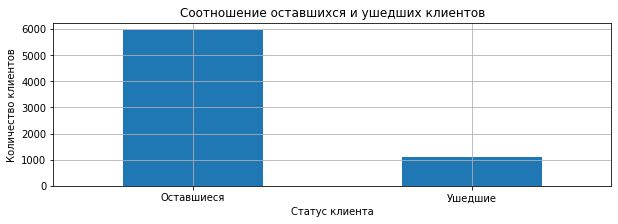

Оставшиеся    5942
Ушедшие       1101
Name: RetentionStatus, dtype: int64


In [28]:
# Определение маппинга для переименования категорий на графике
retention_status_labels = {0: 'Оставшиеся', 1: 'Ушедшие'}

# Преобразование значений для отображения на графике и построение графика
merged['RetentionStatus'].map(retention_status_labels).value_counts().plot(
    kind='bar', 
    grid=True, 
    figsize=(10, 3), 
    title='Соотношение оставшихся и ушедших клиентов'
)

# Настройка отображения заголовка графика и осей
plt.xlabel('Статус клиента')
plt.ylabel('Количество клиентов')

# Поворот подписей
plt.xticks(rotation=360)

# Отображение графика
plt.show()

# Вывод количества значений для проверки
print(merged['RetentionStatus'].value_counts().rename(index=retention_status_labels))

- На лицо дисбаланс, соотношение ушедших клиентов к оставшимся примерно 1:6(на вводной упоминалось более точное значение - 85:15)
    - Следует это учитывать в дальнейшем

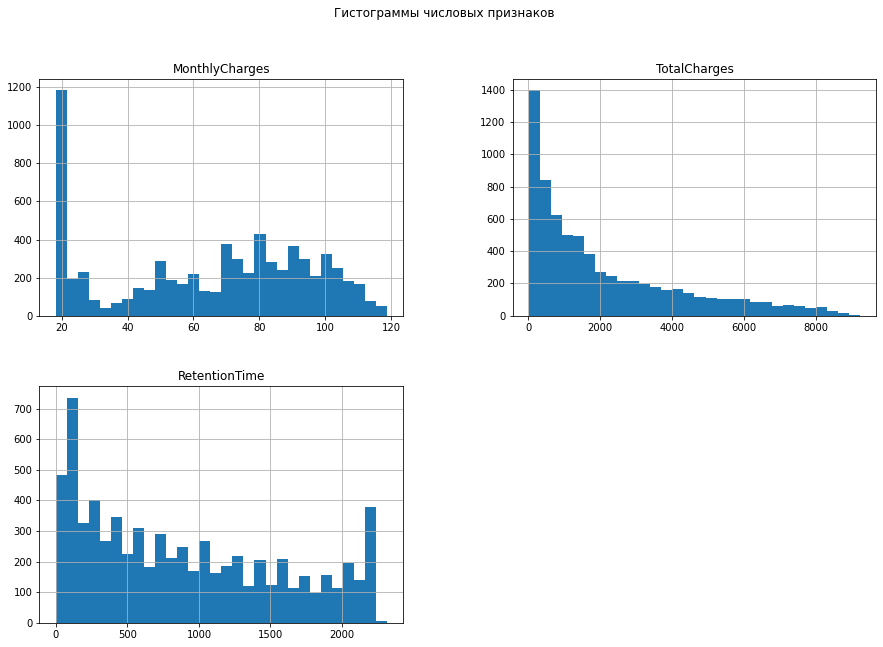

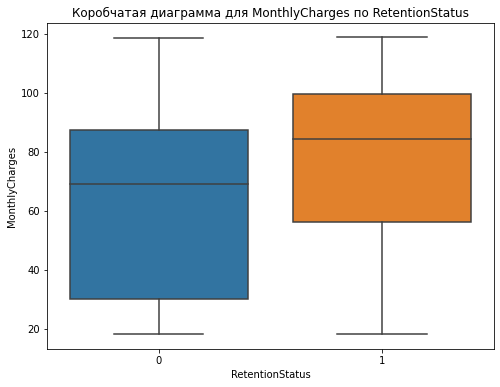

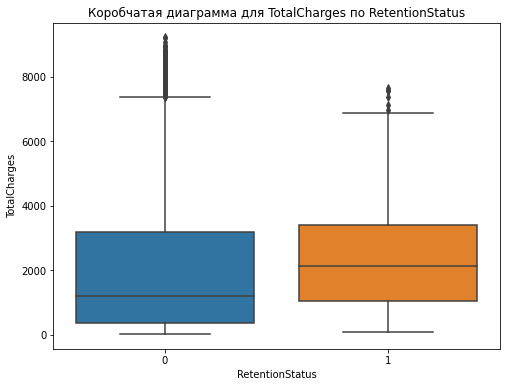

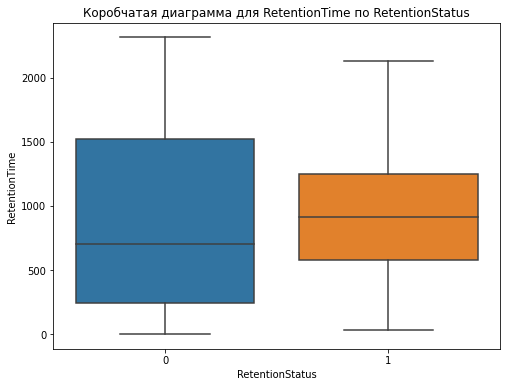

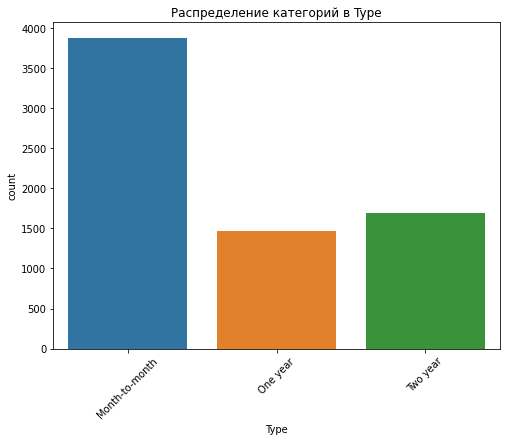

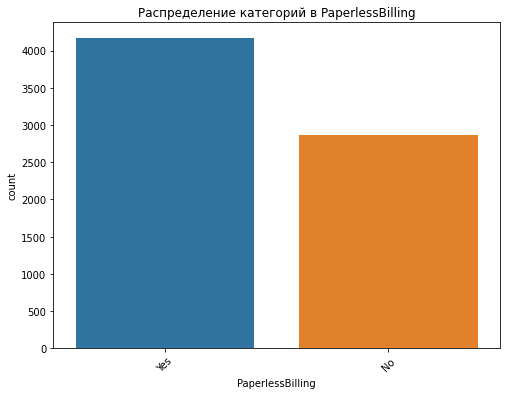

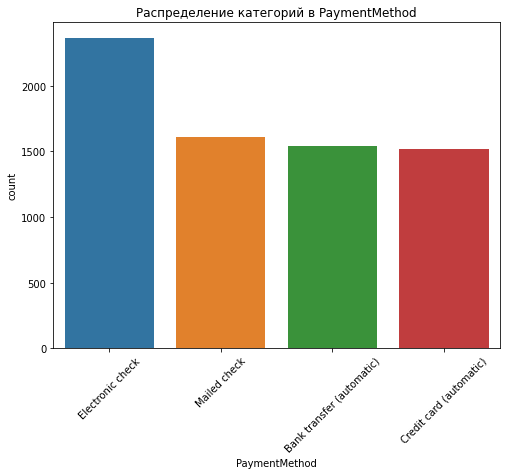

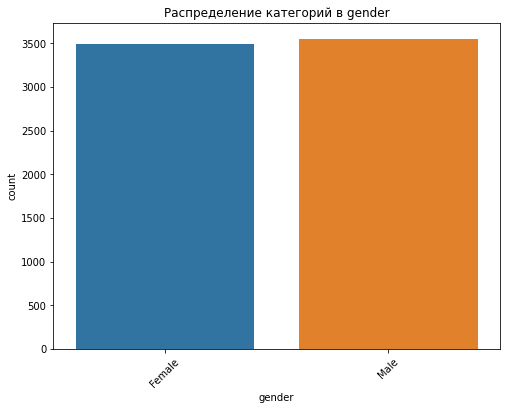

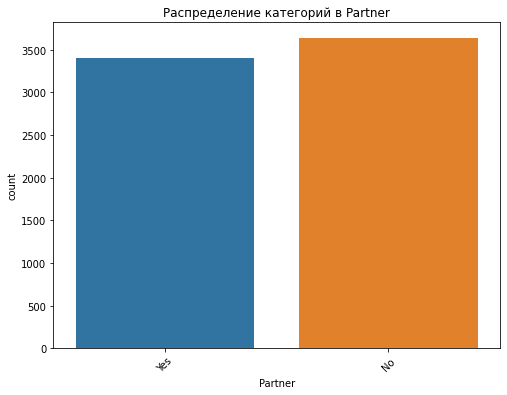

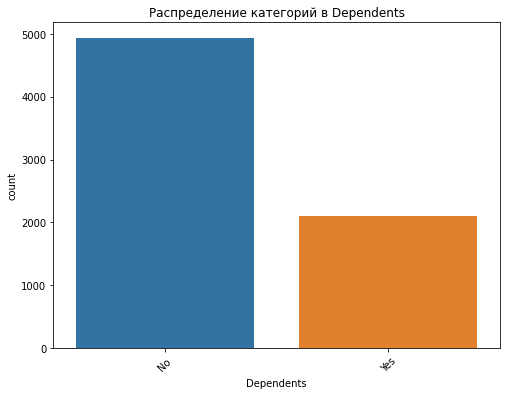

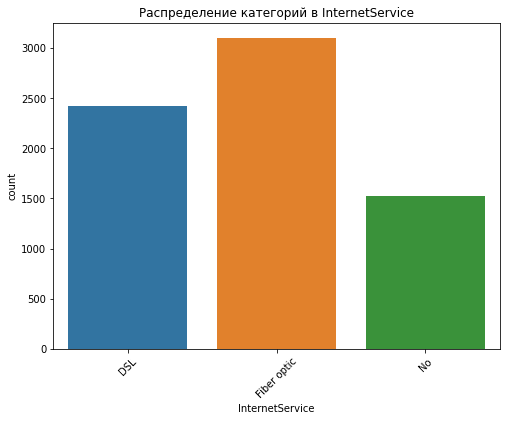

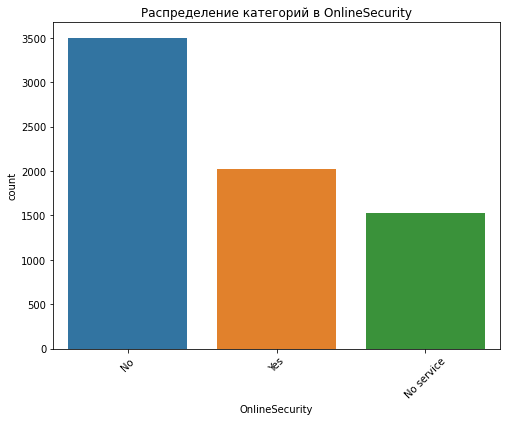

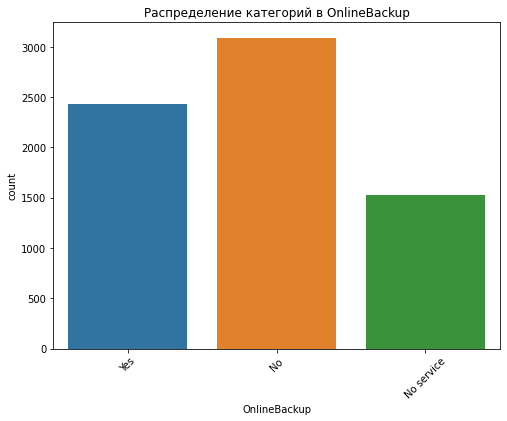

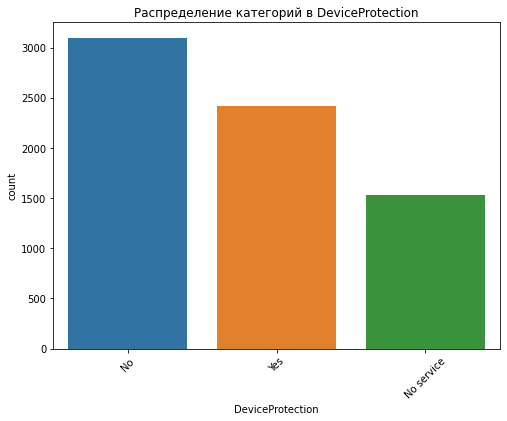

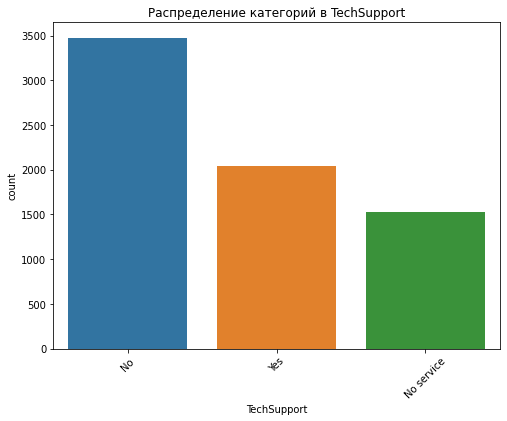

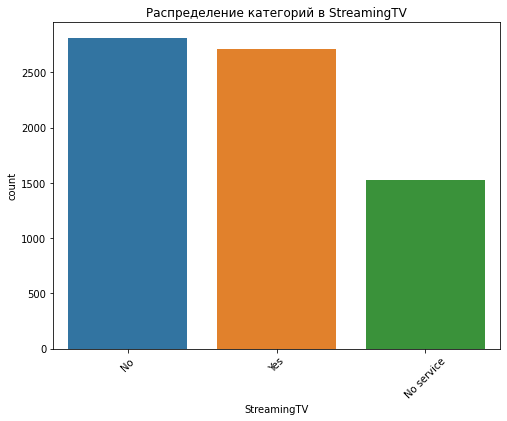

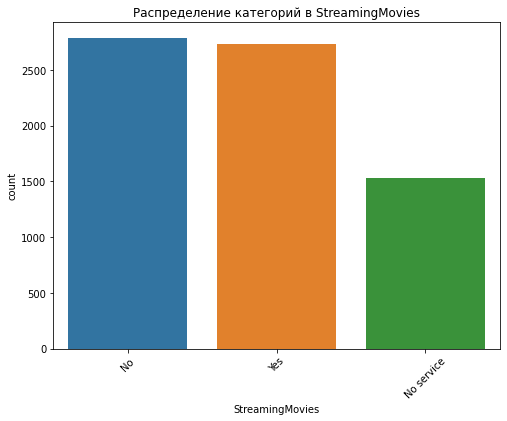

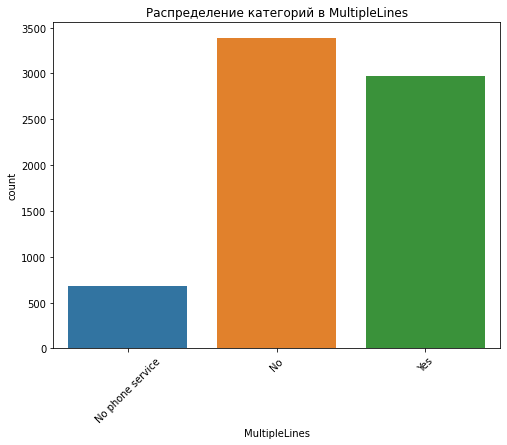

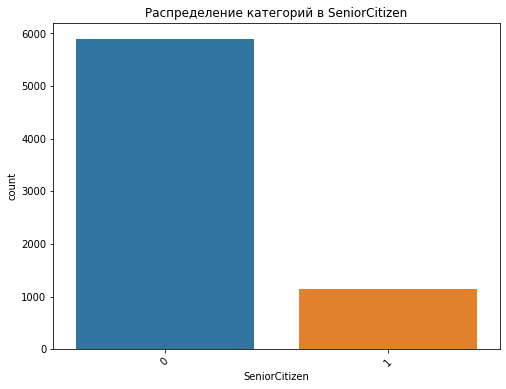

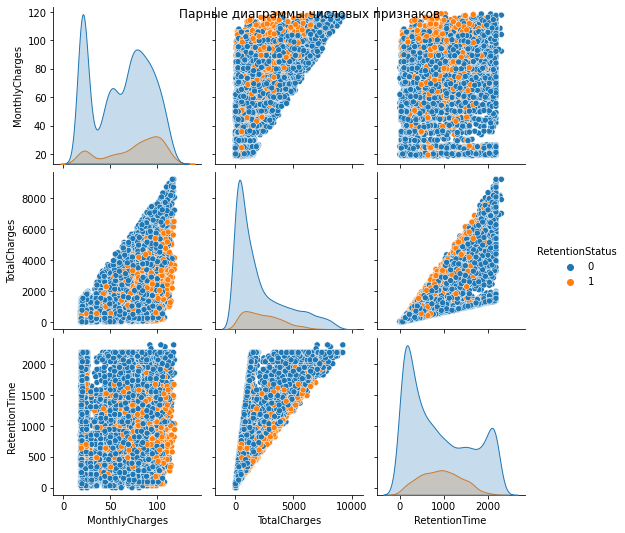

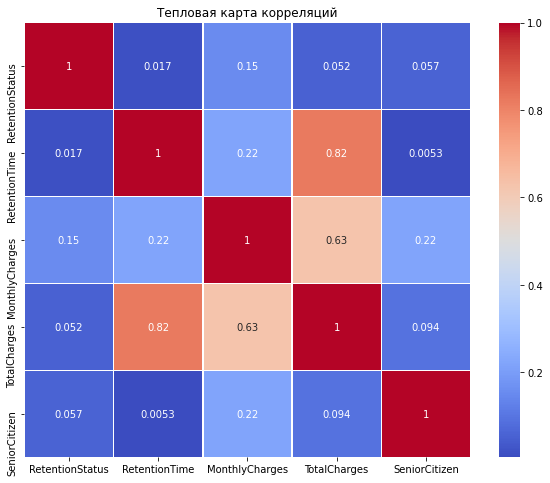

In [29]:
# Гистограммы для числовых признаков
numerical_features = ['MonthlyCharges', 'TotalCharges', 'RetentionTime']
merged[numerical_features].hist(bins=30, figsize=(15, 10))
plt.suptitle('Гистограммы числовых признаков')
plt.show()

# Коробчатые диаграммы (boxplots) для числовых признаков
for feature in numerical_features:
    plt.figure(figsize=(8, 6))
    sns.boxplot(x='RetentionStatus', y=feature, data=merged)
    plt.title(f'Коробчатая диаграмма для {feature} по RetentionStatus')
    plt.show()

# Столбчатые диаграммы для категориальных признаков
categorical_features = ['Type', 'PaperlessBilling', 'PaymentMethod', 'gender', 'Partner', 
                        'Dependents', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 
                        'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 
                        'MultipleLines', 'SeniorCitizen']

for feature in categorical_features:
    plt.figure(figsize=(8, 6))
    sns.countplot(x=feature, data=merged)
    plt.title(f'Распределение категорий в {feature}')
    plt.xticks(rotation=45)
    plt.show()

# Парные диаграммы для числовых признаков и RetentionStatus
sns.pairplot(merged, hue='RetentionStatus', vars=numerical_features)
plt.suptitle('Парные диаграммы числовых признаков')
plt.show()

# Тепловая карта корреляций
plt.figure(figsize=(10, 8))
sns.heatmap(merged.corr(), annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Тепловая карта корреляций')
plt.show()

Просмотрим паттерны зависимости целевого признака от категориальных:

Для проверки гипотез о взаимосвязи между категориальными признаками и целевой переменной можно использовать следующие формулировки:

Нулевая гипотеза (H₀):
- Нет статистически значимых различий в распределении целевой переменной между группами, определяемыми уровнем данного признака.

Альтернативная гипотеза (H₁):
- Есть статистически значимые различия в распределении целевой переменной между группами, определяемыми уровнем данного признака.

In [30]:
def check_significance(feature, merged, target='RetentionStatus'):
    # Формулировка гипотез
    print(f'Проверка признака: {feature}')
    print('Нулевая гипотеза (H₀): Нет статистически значимых различий в распределении целевой переменной между группами признака.')
    print('Альтернативная гипотеза (H₁): Есть статистически значимые различия в распределении целевой переменной между группами признака.')
    print('-' * 50)
    
    # Создание таблицы сопряженности
    contingency_table = pd.crosstab(merged[feature], merged[target])
    
    # Проведение теста хи-квадрат
    chi2, p_value, dof, expected = stats.chi2_contingency(contingency_table)
    
    # Интерпретация результатов
    if p_value < 0.05:
        print(f'Результат для признака {feature}: Найдена статистически значимая разница (p-value = {p_value:.2f}).')
    else:
        print(f'Результат для признака {feature}: Нет статистически значимой разницы (p-value = {p_value:.2f}).')
    print('-' * 50)

# Список категориальных признаков
cat_features = [
    'Type', 'PaperlessBilling', 'PaymentMethod', 'gender', 
    'Partner', 'Dependents', 'InternetService', 'OnlineSecurity', 
    'OnlineBackup', 'DeviceProtection', 'TechSupport', 
    'StreamingTV', 'StreamingMovies', 'MultipleLines', 'SeniorCitizen'
]

# Пример использования функции
for feature in cat_features:
    check_significance(feature, merged)

Проверка признака: Type
Нулевая гипотеза (H₀): Нет статистически значимых различий в распределении целевой переменной между группами признака.
Альтернативная гипотеза (H₁): Есть статистически значимые различия в распределении целевой переменной между группами признака.
--------------------------------------------------
Результат для признака Type: Найдена статистически значимая разница (p-value = 0.00).
--------------------------------------------------
Проверка признака: PaperlessBilling
Нулевая гипотеза (H₀): Нет статистически значимых различий в распределении целевой переменной между группами признака.
Альтернативная гипотеза (H₁): Есть статистически значимые различия в распределении целевой переменной между группами признака.
--------------------------------------------------
Результат для признака PaperlessBilling: Найдена статистически значимая разница (p-value = 0.00).
--------------------------------------------------
Проверка признака: PaymentMethod
Нулевая гипотеза (H₀): Нет 

Не получилось отклонить нулевую гипотезу только по признаку gender.
Можно удалить признак gender ввиду его неинформативности:


In [31]:
merged = merged.drop(['gender'], axis=1)

# Можно сконструировать социальный портрет абонента с высоким риском отказа от услуг компании:

- Не состоящий в браке
- Не имеющий детей, престарелых родителей, инвалидов
- Не достигший пенсионного возраста
- Заключивший договор недавно
- Оплачивающий услуги с безналичной оплатой электронными чеками помесячно
- Имеющий подключение по оптоволоконной связи и не подключающий услуги онлайн-защиты
- Не пользующийся предлагаемыми дополнительными услугами связи

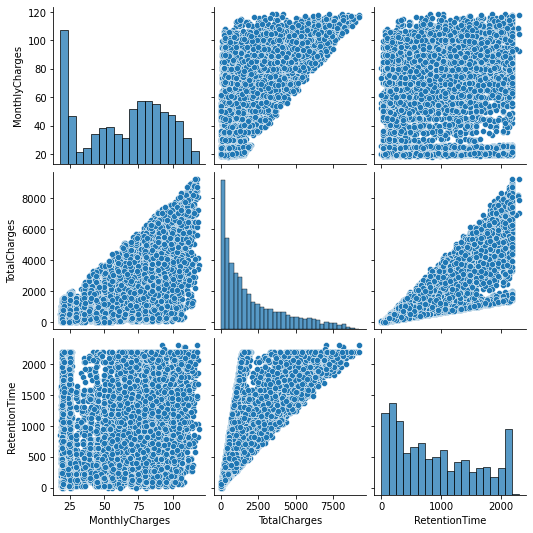

In [32]:
sns.pairplot(merged[['MonthlyCharges', 'TotalCharges', 'RetentionTime']])

Удалим из наших данных столбец TotalCharges, т.к он очень сильно коррелирует со сроком удержания пользователя

In [33]:
merged = merged.drop(labels = ['TotalCharges'], axis = 1)

### Посмотрим и просмотрим матрицу корреляции

In [34]:
interval_cols = ['RetentionTime', 'MonthlyCharges']

,RetentionTime,Type,MonthlyCharges,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
RetentionTime,NaN,0.63,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Type,0.63,NaN,NaN,NaN,NaN,NaN,0.64,NaN,0.63,0.67,NaN,NaN,NaN
MonthlyCharges,NaN,NaN,NaN,NaN,NaN,0.92,0.81,0.82,0.83,0.82,0.86,0.86,0.71
Partner,NaN,NaN,NaN,NaN,0.65,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Dependents,NaN,NaN,NaN,0.65,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
InternetService,NaN,NaN,0.92,NaN,NaN,NaN,0.95,0.94,0.94,0.95,0.95,0.95,0.74
OnlineSecurity,NaN,0.64,0.81,NaN,NaN,0.95,NaN,0.95,0.95,0.95,0.94,0.94,NaN
OnlineBackup,NaN,NaN,0.82,NaN,NaN,0.94,0.95,NaN,0.95,0.95,0.95,0.95,NaN
DeviceProtection,NaN,0.63,0.83,NaN,NaN,0.94,0.95,0.95,NaN,0.95,0.95,0.95,NaN
TechSupport,NaN,0.67,0.82,NaN,NaN,0.95,0.95,0.95,0.95,NaN,0.95,0.95,NaN


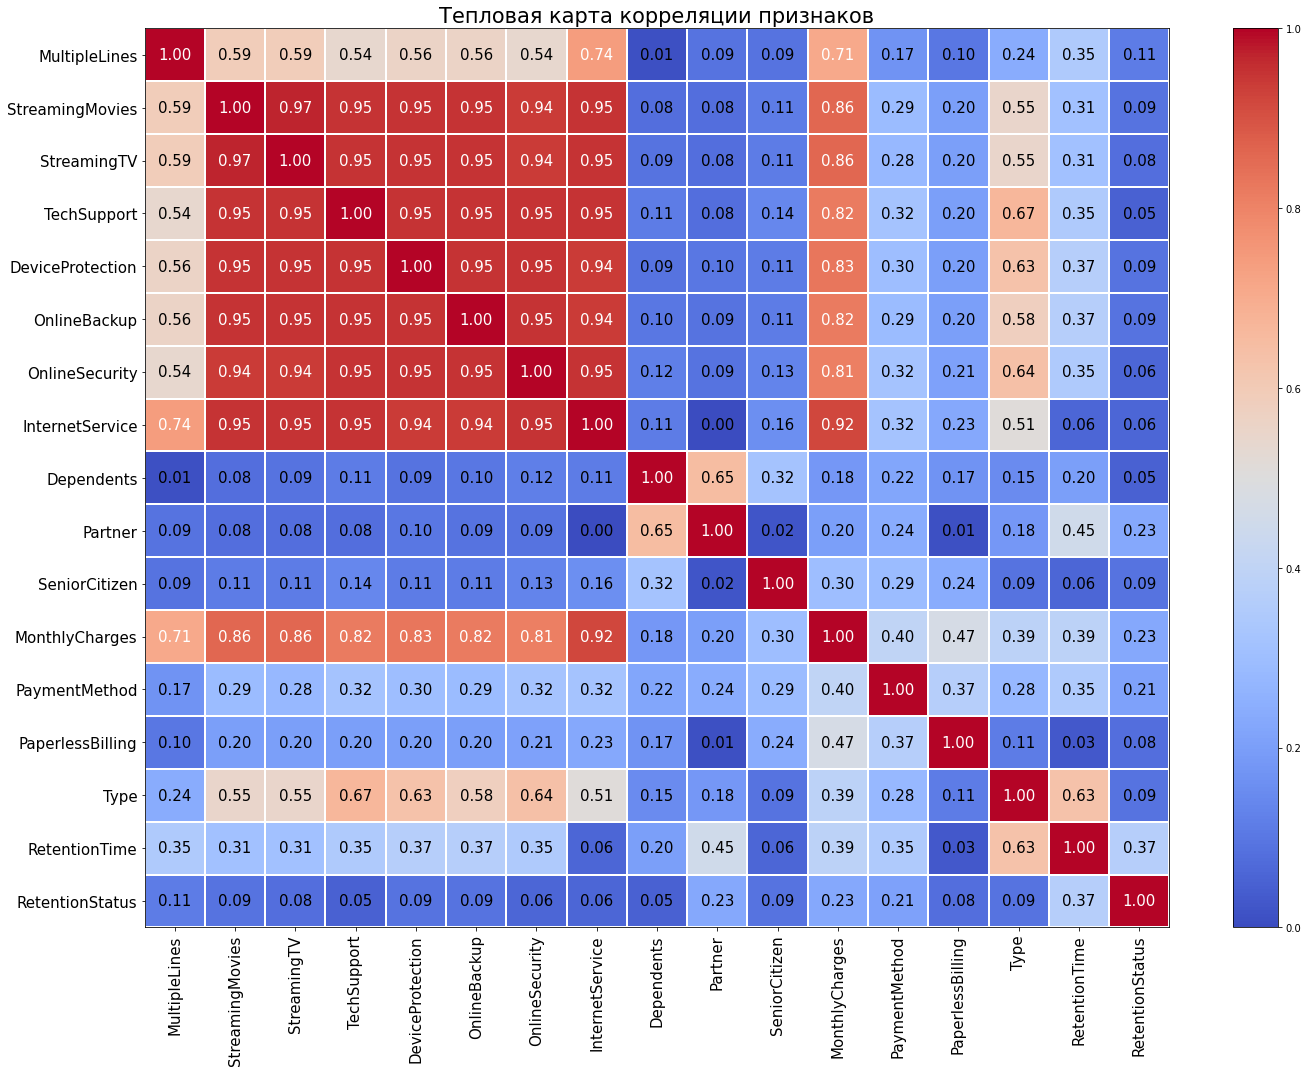

In [35]:
# Вычисление матрицы Phik
phik_overview = merged.phik_matrix(interval_cols=interval_cols).round(2)

# Построение тепловой карты
plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map="coolwarm", 
                        title=r"Тепловая карта корреляции признаков", 
                        fontsize_factor=1.5, 
                        figsize=(20, 15))
plt.tight_layout()

# Установка значения порога корреляции
threshold = 0.6

# Фильтрация матрицы корреляций выше порога
high_correlations = phik_overview[phik_overview > threshold]

# Убираем диагональные элементы (корреляция признака с самим собой)
np.fill_diagonal(high_correlations.values, np.nan)

# Вывод корреляций выше порога
high_correlations.dropna(how='all', axis=0).dropna(how='all', axis=1)

Исходя из полученной карты корреляции можно описать следующие наблюдения:

- MonthlyCharges сильно коррелирет с большинством других признаков, но это очевидно - ежемесячные траты напрямую зависят от подключенных услуг
- RetentionTime коррелирует с Type(очевидно)
- RetentionStatus наибольшую корреляцию показывает с признаками PaymentMethod(удобство) и RetentionTime(постоянство)

Столбцы пока трогать смысла не имеет, в ходе обучения модели будет возможность это изменить.

# Шаг 5. Подготовка данных

Удалим дубликаты

In [36]:
merged = merged.drop_duplicates()

In [37]:
# Список категориальных и числовых признаков
cat_features = [
    'Type', 'PaperlessBilling', 'PaymentMethod', 'Partner',
    'Dependents', 'InternetService', 'OnlineSecurity', 
    'OnlineBackup', 'DeviceProtection', 'TechSupport', 
    'StreamingTV', 'StreamingMovies', 'MultipleLines', 'SeniorCitizen'
]

num_features = ['RetentionTime', 'MonthlyCharges']

Разделим выборки в соотношении 3/1(75:25)(по требованию, упомянутому на вводной)

In [38]:
# Разделение данных на тренировочные и тестовые выборки
X = merged.drop(['RetentionStatus'], axis=1)
y = merged['RetentionStatus']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RANDOM_STATE)

<div class="alert alert-success">
<h2> Комментарий ментора <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> Сплитование выполнено корректно: пропорции выборок соблюдены, константа соответствует значению группы. 
    
Дополнительно можно попробовать стратифицировать выборки по целевому признаку - это позволит получить выборки с равынм соотноешнием классов, что может привести к увеличению качества твоего решения.

In [39]:
for feature in cat_features:
    print("Уникальные значения в столбце", feature, "-", merged[feature].unique())

Уникальные значения в столбце Type - ['Month-to-month' 'One year' 'Two year']
Уникальные значения в столбце PaperlessBilling - ['Yes' 'No']
Уникальные значения в столбце PaymentMethod - ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
Уникальные значения в столбце Partner - ['Yes' 'No']
Уникальные значения в столбце Dependents - ['No' 'Yes']
Уникальные значения в столбце InternetService - ['DSL' 'Fiber optic' 'No']
Уникальные значения в столбце OnlineSecurity - ['No' 'Yes' 'No service']
Уникальные значения в столбце OnlineBackup - ['Yes' 'No' 'No service']
Уникальные значения в столбце DeviceProtection - ['No' 'Yes' 'No service']
Уникальные значения в столбце TechSupport - ['No' 'Yes' 'No service']
Уникальные значения в столбце StreamingTV - ['No' 'Yes' 'No service']
Уникальные значения в столбце StreamingMovies - ['No' 'Yes' 'No service']
Уникальные значения в столбце MultipleLines - ['No phone service' 'No' 'Yes']
Уникальные значения в столбц

In [40]:
# Создание трансформера для кодирования категориальных признаков и масштабирования числовых признаков
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), cat_features),
        ('num', StandardScaler(), num_features)
    ],
    remainder='passthrough'  # Оставить остальные числовые признаки без изменений
)

# Шаг 6. Обучение моделей машинного обучения

In [41]:
def search_best_params(estimator, params, X_train, y_train, cv_folds=5, scoring=None, refit_metric='roc_auc'):
    start_time = time.time()
    
    # Создание пайплайна с предобработкой и моделью
    model_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                     ('classifier', estimator(random_state=RANDOM_STATE))])
    
    if scoring is None:
        scoring = {
            'roc_auc': make_scorer(roc_auc_score, needs_proba=True),
            'accuracy': make_scorer(accuracy_score)
        }
    
    # Поиск по сетке гиперпараметров с кросс-валидацией с использованием нескольких метрик
    grid = GridSearchCV(model_pipeline, param_grid=params, cv=cv_folds, scoring=scoring, refit=refit_metric, n_jobs=-1)
    grid.fit(X_train, y_train)
    
    # Получение индекса лучшей модели
    best_index = grid.best_index_

    # Получение результатов кросс-валидации для всех метрик
    mean_test_scores = {metric: grid.cv_results_[f'mean_test_{metric}'][best_index] for metric in scoring}
    
    print(f"Лучший результат {refit_metric} на кросс-валидации: {mean_test_scores[refit_metric]:.2f}")
    for metric, score in mean_test_scores.items():
        print(f"Средняя {metric} на кросс-валидации: {score:.2f}")
    
    end_time = time.time()
    print(f"Время выполнения: {end_time - start_time:.2f} секунд")
    
    return grid.best_params_, mean_test_scores[refit_metric]

In [42]:
# Параметры для CatBoostClassifier
params_cb = {
    'classifier__iterations': [300, 500],
    'classifier__learning_rate': [0.01, 0.1],
    'classifier__depth': [4, 6],
    'classifier__l2_leaf_reg': [1, 3],
    'classifier__verbose': [False]
}

# Поиск лучших параметров для CatBoostClassifier
best_cb_params, best_cb_score = search_best_params(CatBoostClassifier, params_cb, X_train, y_train)

Лучший результат roc_auc на кросс-валидации: 0.92
Средняя roc_auc на кросс-валидации: 0.92
Средняя accuracy на кросс-валидации: 0.92
Время выполнения: 129.68 секунд


Наилучшим образом показала себя модель CatBoostClassifier, так что используем на тестовых данных именно её

# Шаг 7. Выбор лучшей модели

In [43]:
# Удаляем префикс 'classifier__' из параметров
cleaned_cb_params = {key.replace('classifier__', ''): value for key, value in best_cb_params.items()}

# Создаем модель с очищенными гиперпараметрами
best_cb_model = CatBoostClassifier(**cleaned_cb_params, random_state=RANDOM_STATE)

# Создаем пайплайн с предобработкой и лучшей моделью
final_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                 ('classifier', best_cb_model)])

# Обучение модели на тренировочных данных
final_pipeline.fit(X_train, y_train)

# Прогнозирование на тестовых данных
test_probabilities = final_pipeline.predict_proba(X_test)[:, 1]
test_prediction = final_pipeline.predict(X_test)

# Вычисление метрик
roc_auc = roc_auc_score(y_test, test_probabilities)
accuracy = accuracy_score(y_test, test_prediction)

print(f"Roc_auc лучшей модели на тесте: {roc_auc:.2f}")
print(f"Accuracy лучшей модели на тесте: {accuracy:.2f}")

Roc_auc лучшей модели на тесте: 0.93
Accuracy лучшей модели на тесте: 0.93


Такое значение Accuracy указывает на то, что модель очень хорошо справляется с классификацией клиентов, то есть в 92% случаев модель правильно определяет, уйдет клиент или останется. Это может быть полезно для компании, так как позволяет:

Эффективно удерживать клиентов:
- Предсказывая вероятность ухода клиента, компания может предпринять меры для его удержания.

Оптимизировать ресурсы:
- Зная, какие клиенты с высокой вероятностью останутся, компания может сосредоточить усилия на тех, кто подвержен риску ухода.

Посмотрим список фич в модели:

In [44]:
print(final_pipeline.named_steps['preprocessor'])

ColumnTransformer(remainder='passthrough',
                  transformers=[('cat',
                                 OneHotEncoder(drop='first',
                                               handle_unknown='ignore'),
                                 ['Type', 'PaperlessBilling', 'PaymentMethod',
                                  'Partner', 'Dependents', 'InternetService',
                                  'OnlineSecurity', 'OnlineBackup',
                                  'DeviceProtection', 'TechSupport',
                                  'StreamingTV', 'StreamingMovies',
                                  'MultipleLines', 'SeniorCitizen']),
                                ('num', StandardScaler(),
                                 ['RetentionTime', 'MonthlyCharges'])])


Все фичи на месте - достанем их для корректного отображения в SHAP:

In [45]:
# Функция для получения имен признаков после трансформации
def get_feature_names(preprocessor, X):
    # Применение предобработки к данным
    X_transformed = preprocessor.transform(X)
    
    # Получаем имена признаков из OneHotEncoder
    feature_names = []
    if hasattr(preprocessor.named_transformers_['cat'], 'get_feature_names_out'):
        cat_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out()
        feature_names.extend(cat_feature_names)
    
    # Добавляем имена числовых признаков
    feature_names.extend(num_features)
    
    return feature_names

# Создание модели с отключенным выводом
best_cb_model = CatBoostClassifier(**cleaned_cb_params, random_state=RANDOM_STATE)

# Создание пайплайна с предобработкой и моделью
final_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                 ('classifier', best_cb_model)])

# Обучение модели на тренировочных данных
final_pipeline.fit(X_train, y_train)

# Преобразование тренировочного набора данных
X_train_transformed = final_pipeline.named_steps['preprocessor'].transform(X_train)

# Получение имен признаков после трансформации
feature_names = get_feature_names(preprocessor, X_train)

# Проверка размеров и вывод имен признаков
print(f"Размерность X_train после трансформации: {X_train_transformed.shape}")
print(f"Количество имен признаков: {len(feature_names)}")
print("Имена признаков:")
print(feature_names)

Размерность X_train после трансформации: (5252, 27)
Количество имен признаков: 27
Имена признаков:
['Type_One year', 'Type_Two year', 'PaperlessBilling_Yes', 'PaymentMethod_Credit card (automatic)', 'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check', 'Partner_Yes', 'Dependents_Yes', 'InternetService_Fiber optic', 'InternetService_No', 'OnlineSecurity_No service', 'OnlineSecurity_Yes', 'OnlineBackup_No service', 'OnlineBackup_Yes', 'DeviceProtection_No service', 'DeviceProtection_Yes', 'TechSupport_No service', 'TechSupport_Yes', 'StreamingTV_No service', 'StreamingTV_Yes', 'StreamingMovies_No service', 'StreamingMovies_Yes', 'MultipleLines_No phone service', 'MultipleLines_Yes', 'SeniorCitizen_1', 'RetentionTime', 'MonthlyCharges']


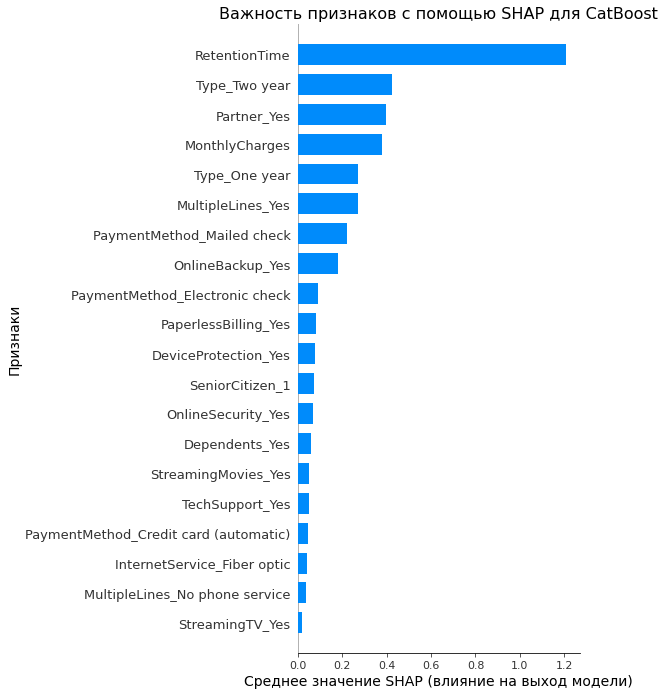

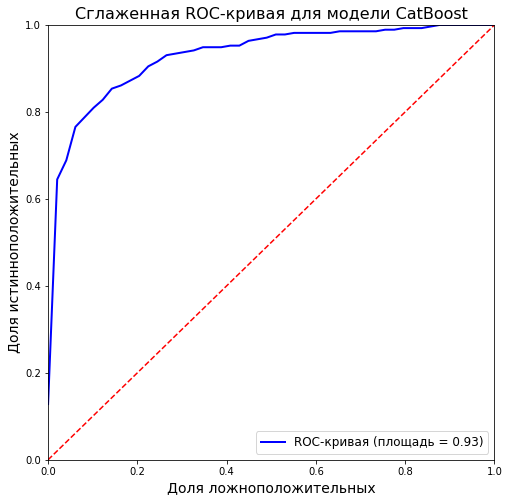

In [46]:
# Создание объекта объяснения SHAP для модели CatBoost
explainer = shap.TreeExplainer(final_pipeline.named_steps['classifier'])

# Получение значений SHAP для тренировочного набора
shap_values = explainer.shap_values(X_train_transformed)

# Визуализация важности признаков с помощью SHAP summary plot
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, X_train_transformed, feature_names=feature_names, plot_type="bar", show=False)
plt.title("Важность признаков с помощью SHAP для CatBoost", fontsize=16)
plt.xlabel("Среднее значение SHAP (влияние на выход модели)", fontsize=14)
plt.ylabel("Признаки", fontsize=14)
plt.show()

# 2. ROC-кривая
# Прогнозирование на тестовом наборе
test_probabilities = final_pipeline.predict_proba(X_test)[:, 1]

# Построение ROC-кривой
fpr, tpr, thresholds = roc_curve(y_test, test_probabilities)
roc_auc = roc_auc_score(y_test, test_probabilities)

# Интерполяция для сглаживания кривой
fpr_new = np.linspace(0, 1, 50)
tpr_interp = interp1d(fpr, tpr, kind='linear')(fpr_new)

# Построение ROC-кривой
plt.figure(figsize=(8, 8))
plt.plot(fpr_new, tpr_interp, color='blue', lw=2, label=f'ROC-кривая (площадь = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('Доля ложноположительных', fontsize=14)
plt.ylabel('Доля истинноположительных', fontsize=14)
plt.title('Сглаженная ROC-кривая для модели CatBoost', fontsize=16)
plt.legend(loc="lower right", fontsize=12)
plt.show()

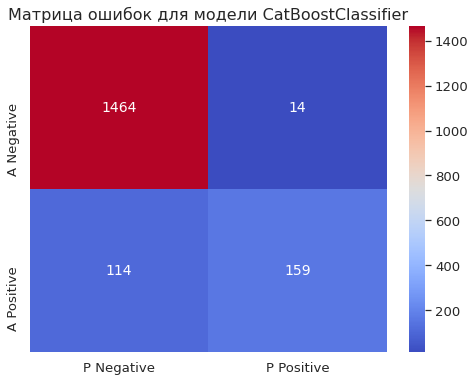

In [47]:
# Прогнозирование классов на тестовом наборе
y_pred = final_pipeline.predict(X_test)

# Создаем матрицу ошибок
df_cm_CatBoostClassifier = pd.DataFrame(confusion_matrix(y_test, y_pred),
                                        index=['A Negative', 'A Positive'],
                                        columns=['P Negative', 'P Positive'])

# Построение тепловой карты матрицы ошибок
sns.set(font_scale=1.2)
plt.figure(figsize=(8, 6))
sns.heatmap(df_cm_CatBoostClassifier, annot=True, cmap='coolwarm', fmt='d', annot_kws={'fontsize':14})

plt.title('Матрица ошибок для модели CatBoostClassifier', fontsize=16)
plt.show()

По матрице ошибок видно, что модель склоняется в True Negative - не пропускает "уходящих" клиентов

A Negative (Actual Negative) — это клиенты, которые действительно остались.
A Positive (Actual Positive) — это клиенты, которые действительно ушли.
P Negative (Predicted Negative) — это клиенты, которых модель предсказала как оставшихся.
P Positive (Predicted Positive) — это клиенты, которых модель предсказала как ушедших.

Матрица ошибок показывает, что:

- Модель имеет высокий показатель True Negative (1461), что означает, что она хорошо предсказывает клиентов, которые останутся в компании.

- Модель правильно предсказывает 157 уходящих клиентов (True Positive), что позволяет компании сосредоточить усилия на удержании этих клиентов.

- Можно обратить внимание на False Negative (116), что говорит о том, что модель иногда пропускает уходящих клиентов, и это может привести к нежелательным потерям для компании, но их количество всего 6.55% от числа клиентов

- С другой стороны, низкое количество False Positive (17) говорит о том, что компания не будет чрезмерно тратить ресурсы на удержание клиентов, которые и так остаются.

# Шаг 8. Общий вывод и рекомендации заказчику

Шаг 1. Загрузка данных
- Была проведена загрузка и базовый осмотр данных

Шаг 2. Исследовательский анализ и предобработка данных
- Проведен исследовательский анализ и выполнена предобработка

Шаг 3. Объединение данных
- Данные были объединены в единый датафрейм по ключу, из которого так же был сделан индекс

Шаг 4. Исследовательский анализ и предобработка данных объединённого датафрейма
- Проведён исследовательский анализ объединённого датафрейма, визуализированы распределения признаков и при необходимости выполнена предобработка. Проведён корреляционный анализ. Использовались не только имеющиеся признаки, но и сгенерированы новые.

Шаг 5. Подготовка данных
- Выполнена подготовка данных для обучения модели. Данные были разделены на две выборки, при масштабировании и кодировании учтены особенности данных и моделей.

Шаг 6. Обучение моделей машинного обучения
- Обучены 3 модели, одна - модель бустинга. Для всех подобрано как минимум два гиперпараметра.

Шаг 7. Выбор лучшей модели
- Выбрана лучшая модель - CatBoostClassifier и проверено её качество на тестовой выборке.

Заказчику можно рекомендовать модель CatBoostClassifier. Она дает требуемые метрики и её обучение не занимает много времени.

Необходимо соблюсти баланс между минимальным FP и FN, чтобы не потратить ресурсы на клиентов, которые не собирались "уходить", и не упустить тех, кто действительно больше не собирался пользоваться услугами.

Был так же сформирован портрет пользователя, который потенциально может перестать пользоваться услугами компаниия - эти данные могут быть полезны бизнесу в дальнейшем

- Не состоящий в браке
- Не имеющий детей, престарелых родителей, инвалидов
- Не достигший пенсионного возраста
- Заключивший договор недавно
- Оплачивающий услуги с безналичной оплатой электронными чеками помесячно
- Имеющий подключение по оптоволоконной связи и не подключающий услуги онлайн-защиты
- Не пользующийся предлагаемыми дополнительными услугами связи